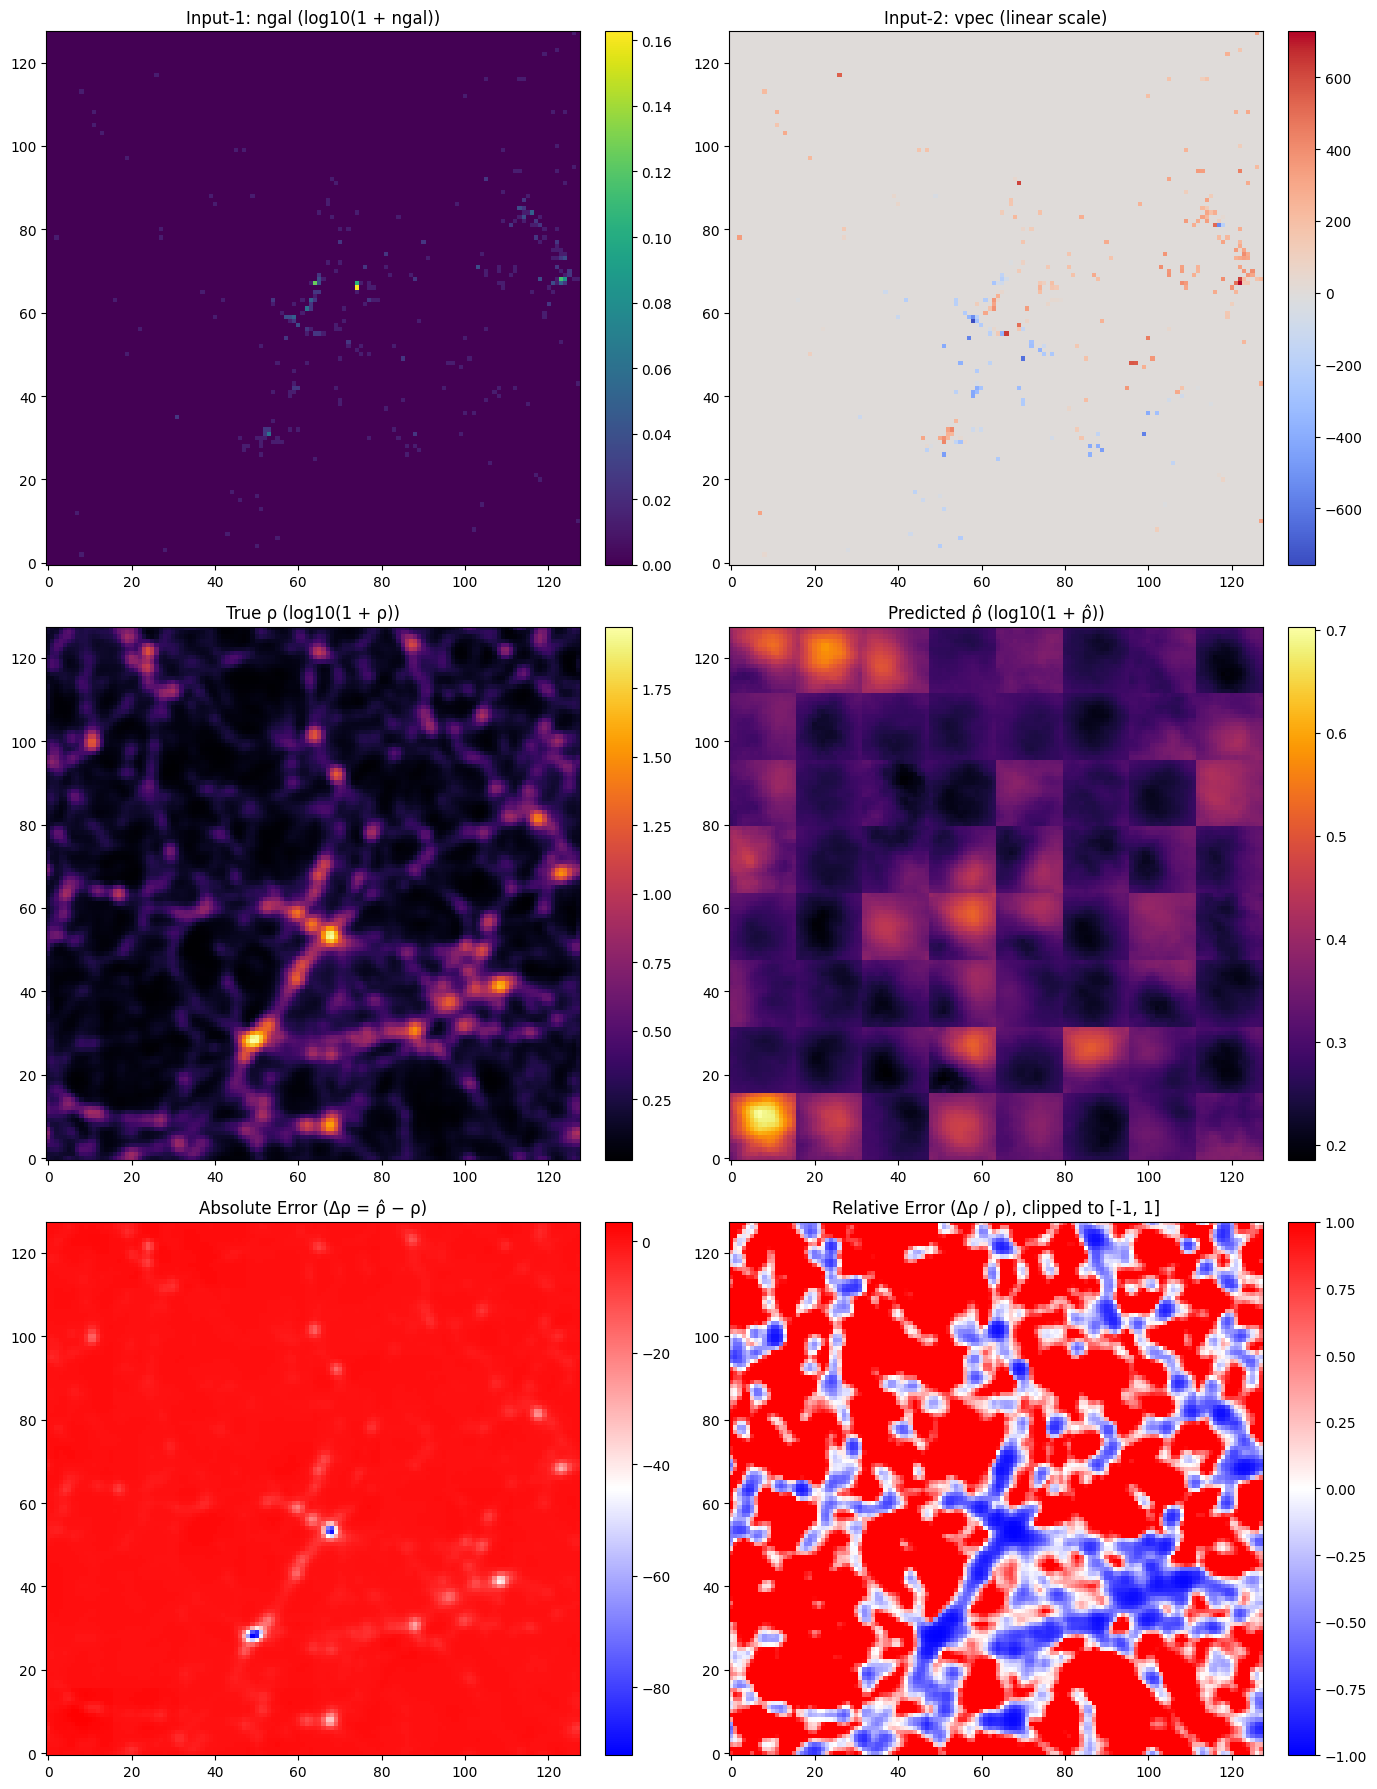

In [1]:
# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_014505"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


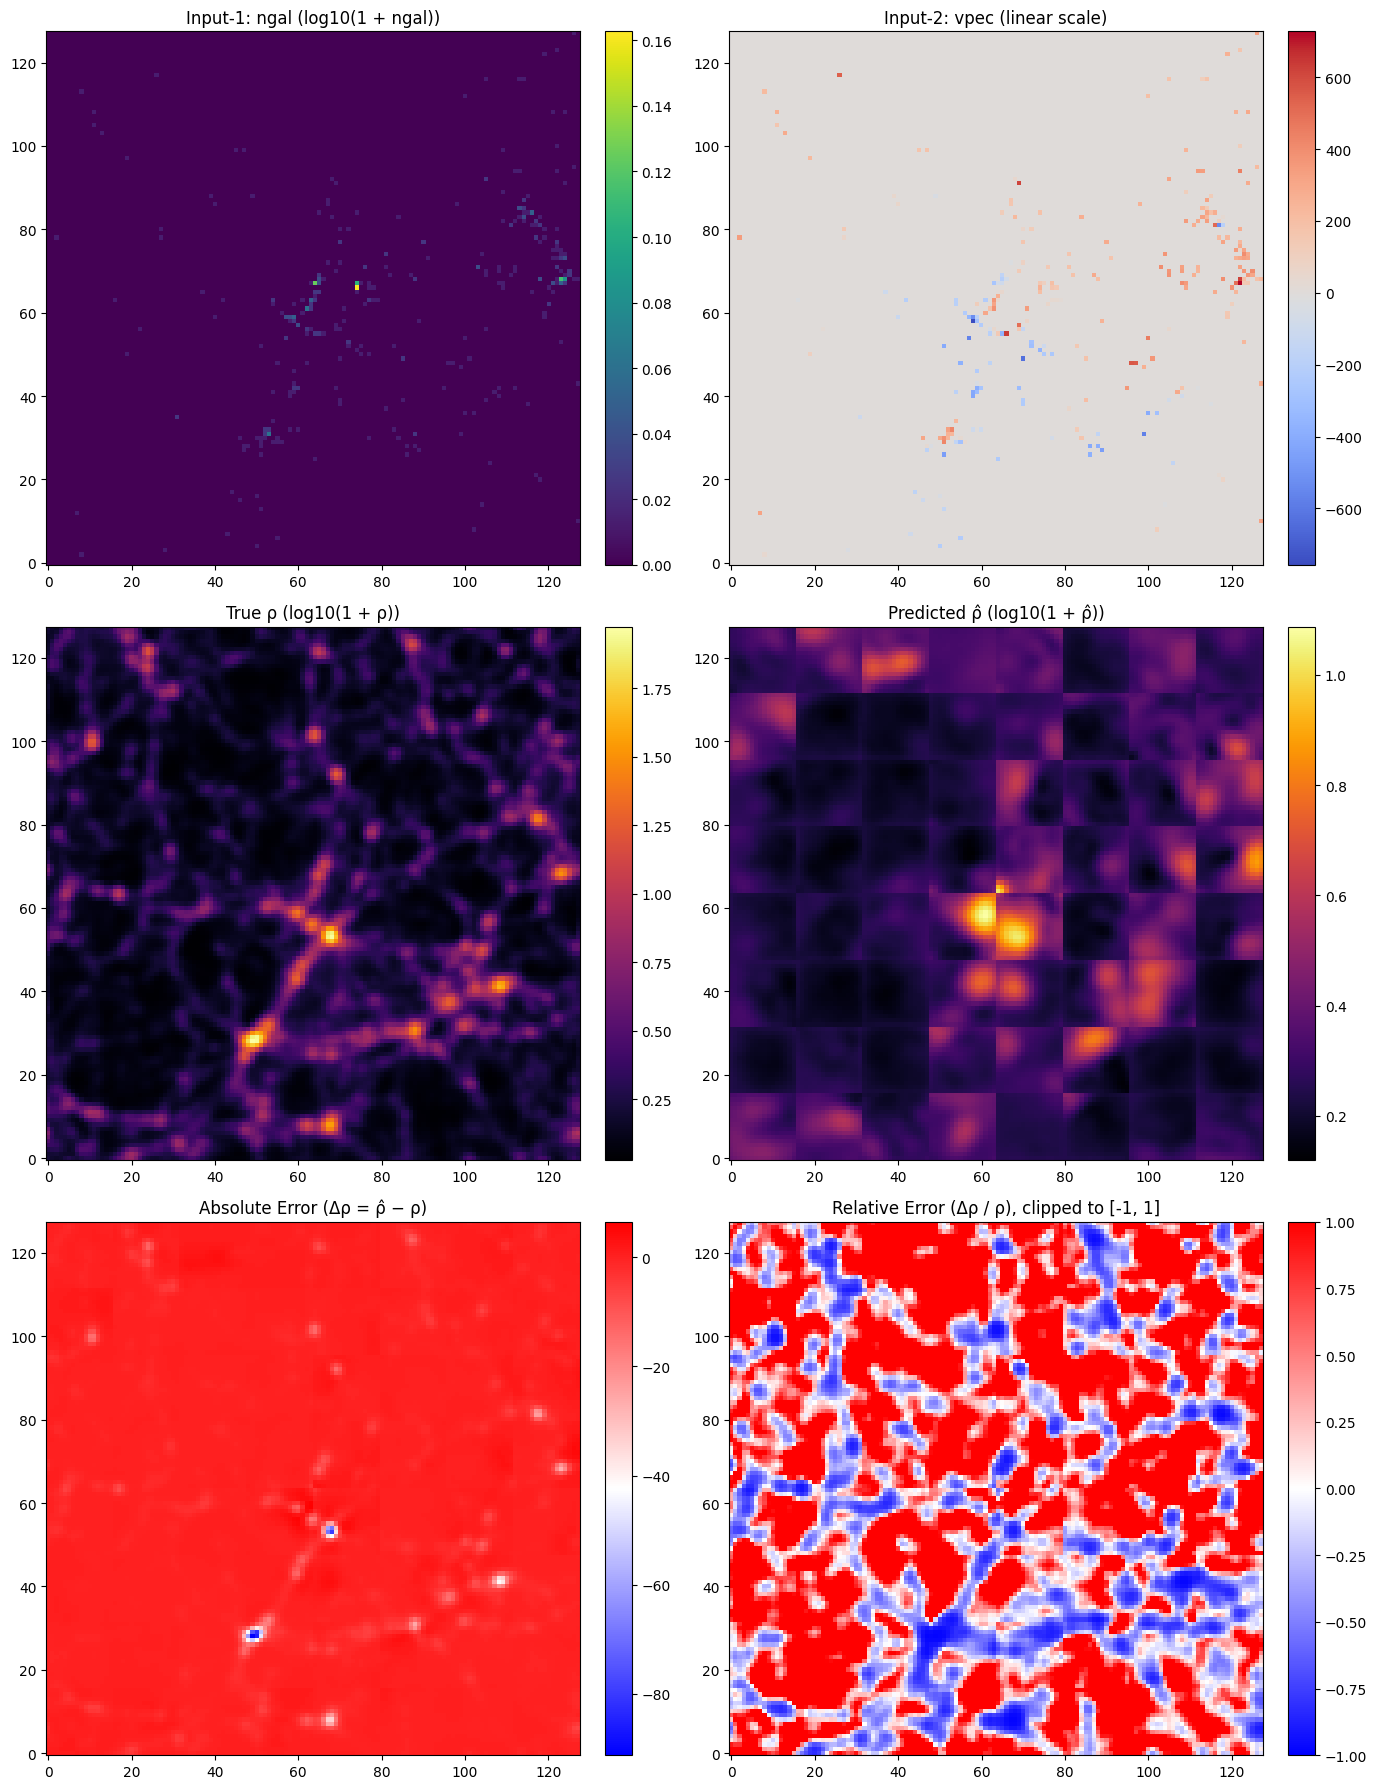

In [2]:
# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_024804"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


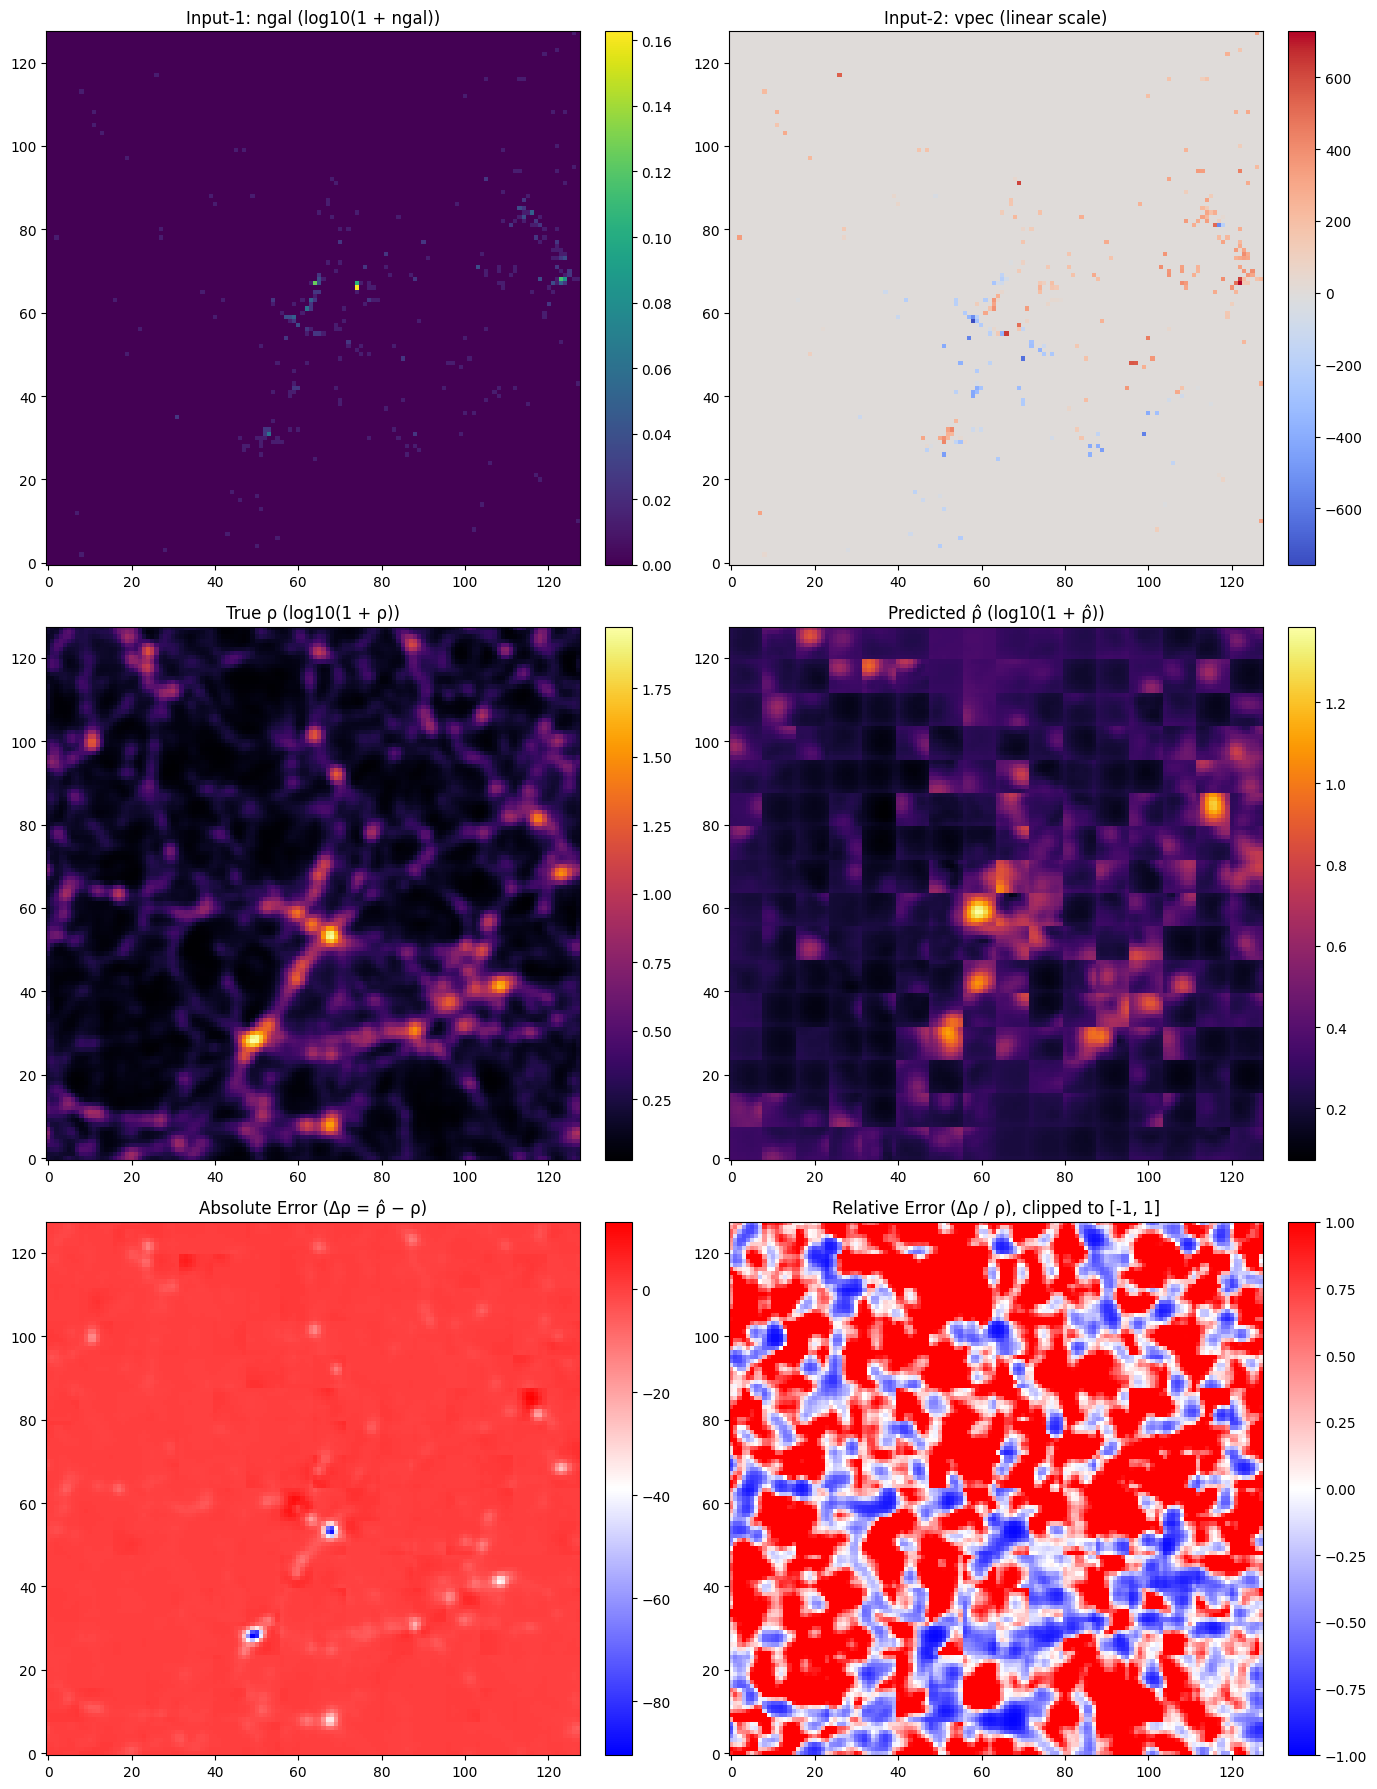

In [1]:


# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/patch8"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


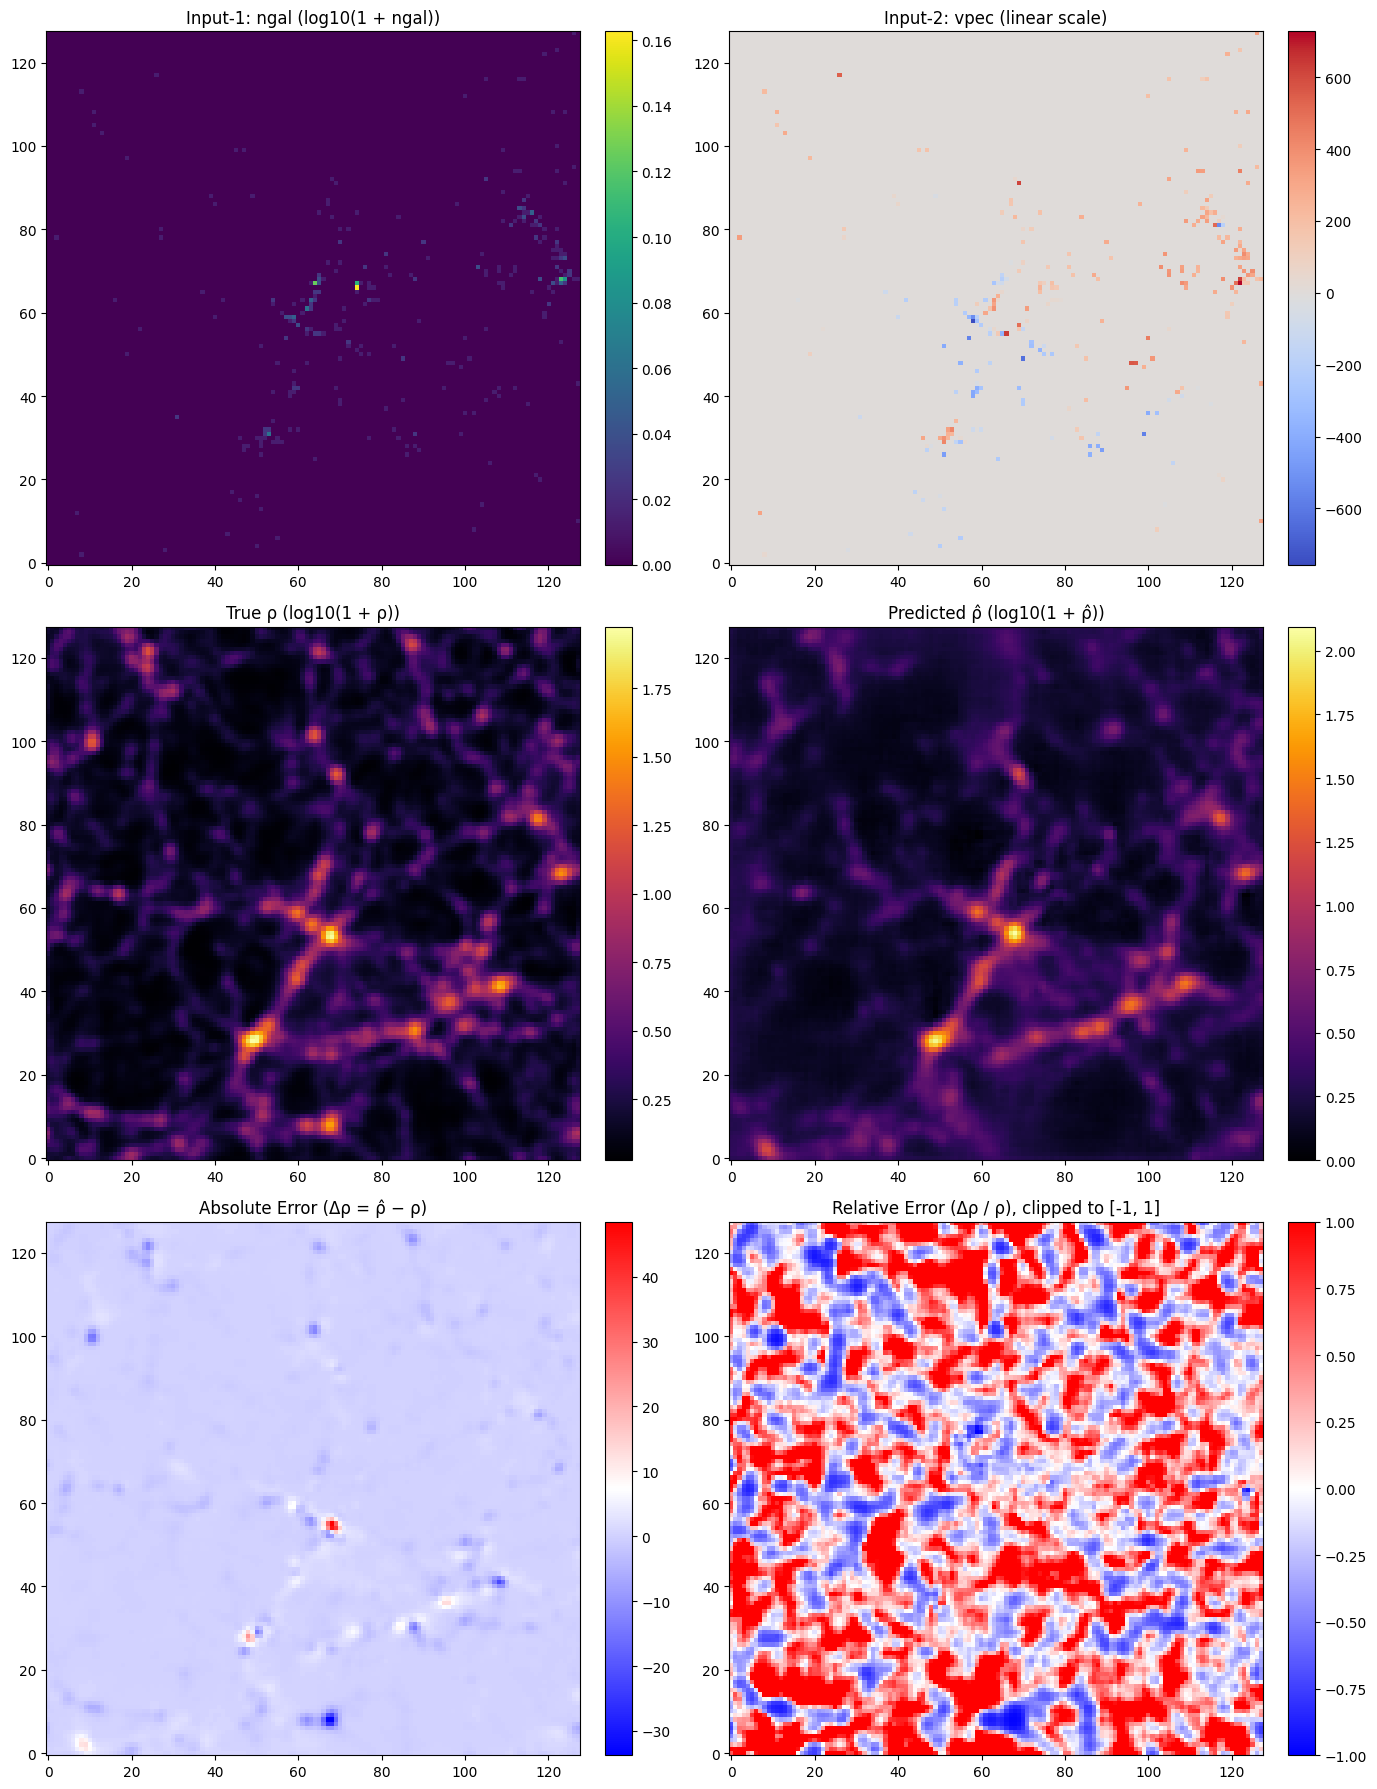

In [1]:

#--------------------------------------
#--------------------------------------
#--------------------------------------
PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
#--------------------------------------
#--------------------------------------
#--------------------------------------

# viz_asim_pred.py
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 설정
# -------------------------------
INDEX = 100  # 시각화할 파일 인덱스 (예: test/100.hdf5)
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"

# 예측 결과 디렉토리 및 파일
#PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/patch8"
PRED_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")

# 어느 슬라이스를 볼지
SLICE_AXIS = 2               # 0: D, 1: H, 2: W
SLICE_INDEX_MODE = "center"  # "center" 또는 정수 인덱스

# -------------------------------
# 유틸
# -------------------------------
def _safesqueeze(arr):
    """앞뒤 불필요한 차원(길이 1)을 제거하되, 최소 3D는 유지."""
    a = np.squeeze(arr)
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim after squeeze: {a.ndim}, shape={a.shape}")
    return a

def _ensure_input_shape(x):
    """
    허용:
      (2, D, H, W)  또는
      (1, 2, D, H, W) 또는 (N, 2, D, H, W) 등
    반환:
      (2, D, H, W)
    """
    arr = x
    if arr.ndim == 4 and arr.shape[0] == 2:
        return arr
    if arr.ndim == 5 and arr.shape[0] == 1 and arr.shape[1] == 2:
        return arr[0]
    if arr.ndim == 5 and arr.shape[1] == 2:
        if arr.shape[0] != 1:
            raise ValueError(f"Got batch N={arr.shape[0]} > 1; 예상과 다릅니다.")
        return arr[0]
    if arr.ndim == 6 and arr.shape[1] == 1 and arr.shape[2] == 2:
        return np.squeeze(arr, axis=0)[0]  # (2,D,H,W)
    raise ValueError(f"Unsupported input shape: {arr.shape}")

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:
        return vol3d[idx, :, :]
    elif axis == 1:
        return vol3d[:, idx, :]
    elif axis == 2:
        return vol3d[:, :, idx]
    else:
        raise ValueError("axis must be 0,1,2")

def _log1p_safe(a):
    # 음수는 0으로 클립 → log1p 적용 (ngal, rho류에 적합)
    return np.log10(1.0 + np.clip(a, 0, None))

# -------------------------------
# 데이터 로드 (Truth & Inputs)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"TEST_FILE not found: {TEST_FILE}")

with h5py.File(TEST_FILE, "r") as f:
    if "input" not in f:
        raise KeyError(f"'input' dataset not found in {TEST_FILE}")
    x = f["input"][:]                      # (1,2,D,H,W) or (2,D,H,W)
    x = _ensure_input_shape(x)             # (2,D,H,W)
    ngal = _safesqueeze(x[0])              # (D,H,W)
    vpec = _safesqueeze(x[1])              # (D,H,W)

    if "output_rho" not in f:
        raise KeyError(f"'output_rho' not found in {TEST_FILE}")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# 데이터 로드 (Prediction)
# -------------------------------
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f"PRED_FILE not found: {PRED_FILE}")

with h5py.File(PRED_FILE, "r") as fp:
    if "prediction" not in fp:
        raise KeyError(f"'prediction' dataset not found in {PRED_FILE}")
    pred = fp["prediction"][:]             # (N,D,H,W) or (D,H,W)
    pred = _safesqueeze(pred)              # (D,H,W)

# -------------------------------
# 슬라이스 선택
# -------------------------------
ngal_slice = _get_slice(ngal, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
vpec_slice = _get_slice(vpec, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_p_slice = _get_slice(pred, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# -------------------------------
# Error maps
# -------------------------------
eps = 1e-6
abs_err_map = rho_p_slice - rho_t_slice
rel_err_map = (rho_p_slice - rho_t_slice) / (rho_t_slice + eps)

# -------------------------------
# 시각화 (3행 × 2열)
# -------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.ravel()

# 1) Inputs
im0 = axes[0].imshow(_log1p_safe(ngal_slice), origin="lower", cmap="viridis")
axes[0].set_title("Input-1: ngal (log10(1 + ngal))")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 주의: vpec는 부호 정보를 살리는 것이 유익할 수 있으므로 선형 스케일을 사용
im1 = axes[1].imshow(vpec_slice, origin="lower", cmap="coolwarm")
axes[1].set_title("Input-2: vpec (linear scale)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 2) Truth / Prediction
im2 = axes[2].imshow(_log1p_safe(rho_t_slice), origin="lower", cmap="inferno")
axes[2].set_title("True ρ (log10(1 + ρ))")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(_log1p_safe(rho_p_slice), origin="lower", cmap="inferno")
axes[3].set_title("Predicted ρ̂ (log10(1 + ρ̂))")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# 3) Absolute / Relative error
im4 = axes[4].imshow(abs_err_map, origin="lower", cmap="bwr")
axes[4].set_title("Absolute Error (Δρ = ρ̂ − ρ)")
plt.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04)

im5 = axes[5].imshow(np.clip(rel_err_map, -1, 1), origin="lower", cmap="bwr", vmin=-1, vmax=1)
axes[5].set_title("Relative Error (Δρ / ρ), clipped to [-1, 1]")
plt.colorbar(im5, ax=axes[5], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [2]:
# compare_metrics.py
import os, glob, h5py, numpy as np, pandas as pd

# -------------------------------
# 고정 입력 (필요 시 아래 세 줄만 바꾸면 됩니다)
# -------------------------------
INDEX = 100
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"
MY_PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
ALEX_PRED_PATTERN = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{INDEX}_final_*.npy"

# -------------------------------
# 공통 유틸
# -------------------------------
def _safesqueeze(a):
    a = np.asarray(a)
    return np.squeeze(a)

def _ensure_finite(y_true, y_pred):
    """비유효값(NaN, inf) 마스크 후 동일 마스크 적용"""
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[mask], y_pred[mask]

def compute_metrics(y_true, y_pred):
    y_true, y_pred = _ensure_finite(y_true, y_pred)
    diff = y_pred - y_true
    mae  = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    bias = float(np.mean(diff))
    # 피어슨 상관
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    if yt.size < 2:
        r = np.nan
    else:
        r = float(np.corrcoef(yt, yp)[0, 1])
    return dict(MAE=mae, RMSE=rmse, Bias=bias, r=r)

# -------------------------------
# 데이터 로드 (Truth)
# -------------------------------
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(TEST_FILE)

with h5py.File(TEST_FILE, "r") as f:
    if "output_rho" not in f:
        raise KeyError("'output_rho' not found in test file")
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# -------------------------------
# my case: HDF5 예측
# -------------------------------
my_pred_file = os.path.join(MY_PRED_DIR, f"{INDEX}.hdf5")
if not os.path.exists(my_pred_file):
    raise FileNotFoundError(my_pred_file)

with h5py.File(my_pred_file, "r") as f:
    if "prediction" not in f:
        raise KeyError("'prediction' dataset not found in my pred file")
    rho_pred_my = _safesqueeze(f["prediction"][:])  # (D,H,W)

# 음수는 물리적 의미가 없으므로 0으로 클립(선택 사항)
rho_true_eval = np.clip(rho_true, 0, None)
rho_pred_my   = np.clip(rho_pred_my, 0, None)

metrics_my = compute_metrics(rho_true_eval, rho_pred_my)

# -------------------------------
# alex case: NPY 예측 (+ 역변환)
# -------------------------------
pred_files = glob.glob(ALEX_PRED_PATTERN)
if not pred_files:
    raise FileNotFoundError(f"No prediction files matched: {ALEX_PRED_PATTERN}")
alex_npy = np.load(pred_files[0])
# 역변환: rho_pred = 10 ** (2.5 * y_rho_p)
rho_pred_alex = np.squeeze(10.0 ** (2.5 * alex_npy))
rho_pred_alex = np.clip(rho_pred_alex, 0, None)

metrics_alex = compute_metrics(rho_true_eval, rho_pred_alex)

# -------------------------------
# 결과 표 출력
# -------------------------------
df = pd.DataFrame.from_dict(
    {"my_case": metrics_my, "alex_case": metrics_alex},
    orient="index",
)[["MAE", "RMSE", "Bias", "r"]]

# 보기 좋은 포맷
with pd.option_context("display.float_format", "{:,.6g}".format):
    print("\n== Regression Metrics (full 3D volume) ==")
    print(df.to_string())



== Regression Metrics (full 3D volume) ==
               MAE    RMSE      Bias        r
my_case   0.549463 1.41268 0.0105511 0.769104
alex_case 0.547909 1.64445 -0.210464 0.690098


In [5]:
# compare_metrics_batch_logged.py
import os, glob, h5py, numpy as np, pandas as pd, time, math, sys
from datetime import datetime

# =========================
# 설정
# =========================
INDEX_LIST = list(range(0, 100))
TEST_DIR = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test"
MY_PRED_DIR = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
ALEX_PRED_PATTERN_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"
CLIP_NEGATIVE = True

# 로깅/체크포인트
LOG_EVERY = 5          # 진행상황 로그 주기(샘플 수)
SAVE_EVERY = 20        # 중간 CSV 저장 주기(샘플 수)
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")  # 파일명 태그

# =========================
# 로깅 유틸
# =========================
def log(msg, *, level="INFO"):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{ts}] [{level}] {msg}")
    sys.stdout.flush()

def fmt_sec(s):
    if s is None or not math.isfinite(s): return "n/a"
    m, s = divmod(int(s), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

def running_mean(rows):
    """rows: list of dicts with keys MAE, RMSE, Bias, r"""
    if not rows: return None
    df = pd.DataFrame(rows)
    return {k: float(df[k].mean()) for k in ["MAE", "RMSE", "Bias, r".split()[0]]}  # quick safeguard

# =========================
# 메트릭 유틸
# =========================
def _safesqueeze(a):
    return np.squeeze(np.asarray(a))

def _ensure_finite(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    return y_true[m], y_pred[m]

def compute_metrics(y_true, y_pred):
    y_true, y_pred = _ensure_finite(y_true, y_pred)
    diff = y_pred - y_true
    mae  = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff**2)))
    bias = float(np.mean(diff))
    y = y_true.reshape(-1); yhat = y_pred.reshape(-1)
    r = float(np.corrcoef(y, yhat)[0,1]) if y.size >= 2 else np.nan
    return dict(MAE=mae, RMSE=rmse, Bias=bias, r=r)

# =========================
# 로더
# =========================
def load_truth(index):
    fpath = os.path.join(TEST_DIR, f"{index}.hdf5")
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Truth not found: {fpath}")
    with h5py.File(fpath, "r") as f:
        if "output_rho" not in f:
            raise KeyError("'output_rho' not found")
        rho_true = _safesqueeze(f["output_rho"][:])
    return rho_true

def load_my_pred(index):
    fpath = os.path.join(MY_PRED_DIR, f"{index}.hdf5")
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"My pred not found: {fpath}")
    with h5py.File(fpath, "r") as f:
        if "prediction" not in f:
            raise KeyError("'prediction' not found in my pred file")
        pred = _safesqueeze(f["prediction"][:])
    return pred

def load_alex_pred(index):
    pattern = ALEX_PRED_PATTERN_TPL.format(idx=index)
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No alex pred matched: {pattern}")
    y_rho_p = np.load(files[0])
    rho_pred = np.squeeze(10.0 ** (2.5 * y_rho_p))  # 역변환
    return rho_pred

# =========================
# 메인 루프
# =========================
rows_my, rows_alex = [], []
miss_my, miss_alex, miss_truth = [], [], []

total = len(INDEX_LIST)
t0 = time.time()
log(f"Start evaluation: {total} samples (clip_negative={CLIP_NEGATIVE})")

for n_done, idx in enumerate(INDEX_LIST, start=1):
    t_iter0 = time.time()
    try:
        rho_true = load_truth(idx)
    except Exception as e:
        miss_truth.append((idx, str(e)))
        log(f"index={idx}: skip (truth missing: {e})", level="WARN")
        continue

    try:
        rho_my = load_my_pred(idx)
    except Exception as e:
        miss_my.append((idx, str(e)))
        rho_my = None
        log(f"index={idx}: my pred missing: {e}", level="WARN")

    try:
        rho_alex = load_alex_pred(idx)
    except Exception as e:
        miss_alex.append((idx, str(e)))
        rho_alex = None
        log(f"index={idx}: alex pred missing: {e}", level="WARN")

    # 클리핑
    if CLIP_NEGATIVE:
        rho_true_eval = np.clip(rho_true, 0, None)
        if rho_my   is not None: rho_my   = np.clip(rho_my,   0, None)
        if rho_alex is not None: rho_alex = np.clip(rho_alex, 0, None)
    else:
        rho_true_eval = rho_true

    # 메트릭 계산
    if rho_my is not None:
        m = compute_metrics(rho_true_eval, rho_my); m["index"] = idx
        rows_my.append(m)
    if rho_alex is not None:
        m = compute_metrics(rho_true_eval, rho_alex); m["index"] = idx
        rows_alex.append(m)

    # 진행 로그
    if (n_done % LOG_EVERY) == 0 or n_done == total:
        elapsed = time.time() - t0
        rate = n_done / max(elapsed, 1e-9)
        remain = (total - n_done) / max(rate, 1e-9)

        def _ravg(rows):
            if not rows: return "n/a"
            df = pd.DataFrame(rows)
            return " | ".join([f"MAE {df['MAE'].mean():.4f}",
                               f"RMSE {df['RMSE'].mean():.4f}",
                               f"Bias {df['Bias'].mean():+.4f}",
                               f"r {df['r'].mean():.4f}"])
        log(f"[{n_done}/{total}] elapsed {fmt_sec(elapsed)} | ETA {fmt_sec(remain)} "
            f"| my(avg): {_ravg(rows_my)} | alex(avg): {_ravg(rows_alex)}")

    # 중간 저장
    if (n_done % SAVE_EVERY) == 0 or n_done == total:
        if rows_my:
            pd.DataFrame(rows_my).set_index("index").sort_index() \
              .to_csv(f"metrics_my_case_running_{RUN_TAG}.csv")
        if rows_alex:
            pd.DataFrame(rows_alex).set_index("index").sort_index() \
              .to_csv(f"metrics_alex_case_running_{RUN_TAG}.csv")

# =========================
# 집계 및 출력(최종)
# =========================
def summarize(rows, name):
    if not rows:
        log(f"No rows for {name}", level="WARN")
        return None, None
    df = pd.DataFrame(rows).set_index("index").sort_index()
    agg = df.agg(["mean", "std", "count"])
    print(f"\n== {name} metrics over {int(agg.loc['count','MAE'])} samples ==")
    with pd.option_context("display.float_format", "{:,.6g}".format):
        print(agg[["MAE","RMSE","Bias","r"]].to_string())
    return df, agg

df_my,  agg_my  = summarize(rows_my,  "my_case")
df_ax,  agg_ax  = summarize(rows_alex,"alex_case")

# 누락 요약
if miss_truth: log(f"Missing truth  : {len(miss_truth)} (first 5: {miss_truth[:5]})", level="INFO")
if miss_my:    log(f"Missing my pred: {len(miss_my)} (first 5: {miss_my[:5]})", level="INFO")
if miss_alex:  log(f"Missing alex   : {len(miss_alex)} (first 5: {miss_alex[:5]})", level="INFO")

# 최종 CSV 저장
if df_my is not None:  df_my.to_csv(f"metrics_my_case_{RUN_TAG}.csv")
if df_ax is not None:  df_ax.to_csv(f"metrics_alex_case_{RUN_TAG}.csv")

log(f"Done. total elapsed: {fmt_sec(time.time()-t0)}")


[2025-10-15 15:35:57] [INFO] Start evaluation: 100 samples (clip_negative=True)
[2025-10-15 15:35:58] [INFO] [5/100] elapsed 00:00:01 | ETA 00:00:24 | my(avg): MAE 0.5736 | RMSE 1.6927 | Bias +0.0125 | r 0.7295 | alex(avg): MAE 0.8886 | RMSE 2.3826 | Bias +0.0624 | r 0.5120
[2025-10-15 15:36:00] [INFO] [10/100] elapsed 00:00:02 | ETA 00:00:23 | my(avg): MAE 0.5740 | RMSE 1.7012 | Bias +0.0174 | r 0.7360 | alex(avg): MAE 1.0879 | RMSE 2.5841 | Bias +0.1867 | r 0.2803
[2025-10-15 15:36:01] [INFO] [15/100] elapsed 00:00:03 | ETA 00:00:21 | my(avg): MAE 0.5721 | RMSE 1.6838 | Bias +0.0177 | r 0.7386 | alex(avg): MAE 0.9574 | RMSE 2.4084 | Bias +0.0846 | r 0.3555
[2025-10-15 15:36:02] [INFO] [20/100] elapsed 00:00:05 | ETA 00:00:20 | my(avg): MAE 0.5726 | RMSE 1.6794 | Bias +0.0171 | r 0.7330 | alex(avg): MAE 1.0200 | RMSE 2.4589 | Bias +0.1278 | r 0.2764
[2025-10-15 15:36:04] [INFO] [25/100] elapsed 00:00:06 | ETA 00:00:19 | my(avg): MAE 0.5736 | RMSE 1.6690 | Bias +0.0182 | r 0.7331 | ale

[INFO] Alex prediction seems overdensity (δ). Applying ρ = δ + 1 correction.


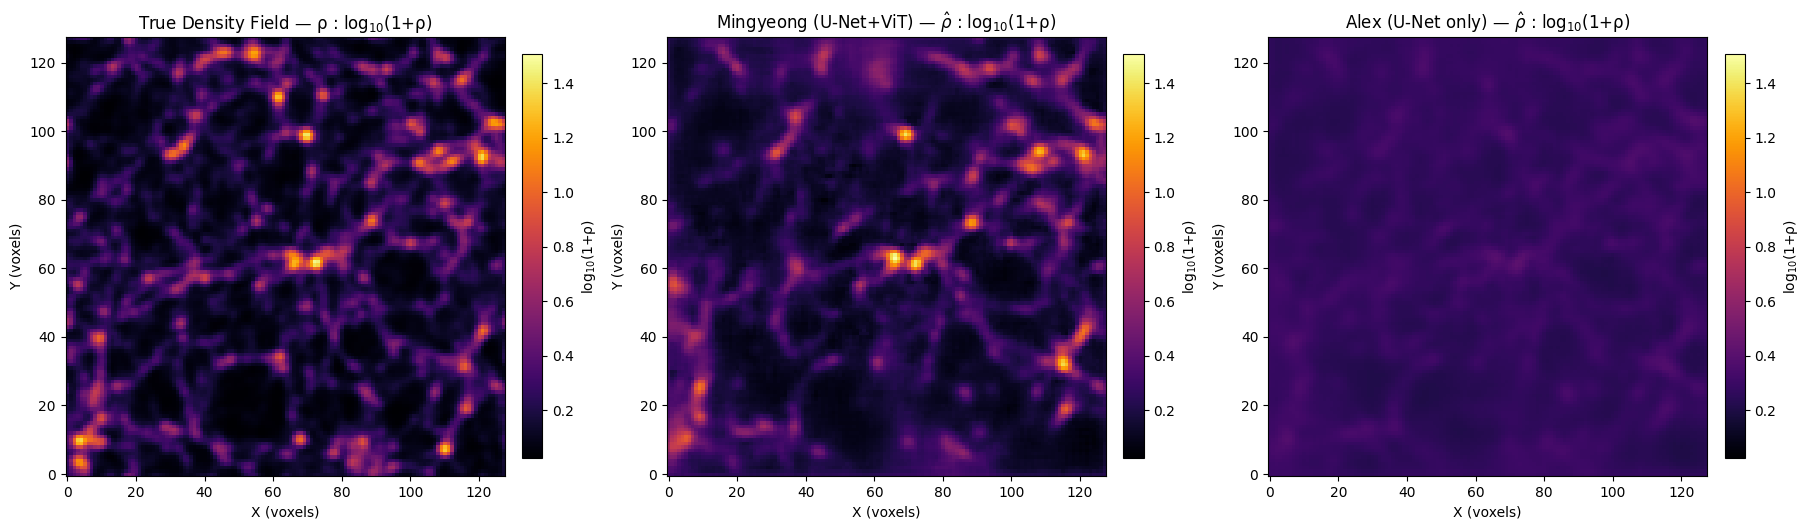

[INFO] Saved figure: compare_true_ming_alex_INDEX50.png
[INFO] True : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/50.hdf5
[INFO] Ming : /home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016/50.hdf5
[INFO] Alex : /scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_50_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy


In [3]:
# -*- coding: utf-8 -*-
"""
Compare 3 maps side-by-side:
  1. True density (ρ_true)
  2. Mingyeong (U-Net+ViT)
  3. Alex (U-Net only)
All displayed in log10(1+ρ) scale with common vmin/vmax.
"""

import os, glob, h5py
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# User settings
# ===============================
INDEX = 100
SLICE_AXIS = 2              # 0,1,2 중 선택
SLICE_INDEX_MODE = "center" # "center" 또는 int
SAVE_FIG = True
OUTFIG = f"compare_true_ming_alex_INDEX{INDEX}.png"

# 파일 경로
TEST_FILE = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{INDEX}.hdf5"
PRED_DIR  = "/home/mingyeong/2510_GAL2DM_ASIM_ViT/results/vit_predictions/20251014_210016"
MING_FILE = os.path.join(PRED_DIR, f"{INDEX}.hdf5")
ALEX_PRED_PATTERN_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/test_{idx}_final_*.npy"

# ===============================
# Utilities
# ===============================
def _safesqueeze(a):
    a = np.squeeze(np.asarray(a))
    if a.ndim < 3:
        raise ValueError(f"Unexpected ndim {a.ndim} for shape {a.shape}")
    return a

def _get_slice(vol3d, axis=2, idx="center"):
    if idx == "center":
        idx = vol3d.shape[axis] // 2
    if axis == 0:   return vol3d[idx,:,:]
    elif axis == 1: return vol3d[:,idx,:]
    elif axis == 2: return vol3d[:,:,idx]
    else: raise ValueError("axis must be 0,1,2")

def _log10p(a):
    return np.log10(1.0 + np.clip(a, 0, None))

# ===============================
# Load true density
# ===============================
with h5py.File(TEST_FILE, "r") as f:
    rho_true = _safesqueeze(f["output_rho"][:])  # (D,H,W)

# ===============================
# Load Mingyeong prediction
# ===============================
with h5py.File(MING_FILE, "r") as f:
    rho_ming = _safesqueeze(f["prediction"][:])

# ===============================
# Load Alex prediction (NPY)
# ===============================
npy_pattern = ALEX_PRED_PATTERN_TPL.format(idx=INDEX)
npy_list = sorted(glob.glob(npy_pattern))
if len(npy_list) == 0:
    raise FileNotFoundError(f"No Alex npy found: {npy_pattern}")
ALEX_FILE = npy_list[0]
rho_alex = _safesqueeze(np.load(ALEX_FILE))

# ===============================
# Heuristic: detect overdensity (δ) vs absolute ρ
# ===============================
alex_min, alex_max = rho_alex.min(), rho_alex.max()
assume_overdensity = alex_min < 0 or alex_max < 1.0
if assume_overdensity:
    print(f"[INFO] Alex prediction seems overdensity (δ). Applying ρ = δ + 1 correction.")
    rho_alex = rho_alex + 1.0

# ===============================
# Slice extraction
# ===============================
rho_t_slice = _get_slice(rho_true, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_m_slice = _get_slice(rho_ming, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)
rho_a_slice = _get_slice(rho_alex, axis=SLICE_AXIS, idx=SLICE_INDEX_MODE)

# ===============================
# Visualization transform (log10(1+ρ))
# ===============================
true_img = _log10p(rho_t_slice)
ming_img = _log10p(rho_m_slice)
alex_img = _log10p(rho_a_slice)

# 공통 색상 스케일
vmin = min(true_img.min(), ming_img.min(), alex_img.min())
vmax = max(true_img.max(), ming_img.max(), alex_img.max())

# ===============================
# Plot (1×3)
# ===============================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

titles = [
    "True Density Field — ρ : log$_{10}$(1+ρ)",
    "Mingyeong (U-Net+ViT) — $\hat{\\rho}$ : log$_{10}$(1+ρ)",
    "Alex (U-Net only) — $\hat{\\rho}$ : log$_{10}$(1+ρ)"
]
images = [true_img, ming_img, alex_img]

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("X (voxels)")
    ax.set_ylabel("Y (voxels)")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("log$_{10}$(1+ρ)")

if SAVE_FIG:
    plt.savefig(OUTFIG, dpi=200)
plt.show()

print(f"[INFO] Saved figure: {OUTFIG}")
print(f"[INFO] True : {TEST_FILE}")
print(f"[INFO] Ming : {MING_FILE}")
print(f"[INFO] Alex : {ALEX_FILE}")
